# Tweets Mining (SNAP-X)
**University of Pavia**

*Web and Social Network Search and Analysis*

**Michele Ventimiglia**
**Manuel Dellabona**

---

## Setup

In [2]:
%pip install -q -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


Libraries import

In [1]:
# Standard Library
import os
import re
import bz2
import json
import logging
from pathlib import Path
from collections import Counter, defaultdict
from typing import Union, Any, Optional, List, Tuple
from concurrent.futures import ThreadPoolExecutor, as_completed

# Thrid-Party Packages
import torch
import spacy
import numpy as np
import pandas as pd
import networkx as nx
import pyterrier as pt
from tqdm.notebook import tqdm
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from scipy.special import softmax
from scipy.ndimage import gaussian_filter1d
from matplotlib.colors import LinearSegmentedColormap
from transformers import AutoModelForSequenceClassification, AutoTokenizer, AutoConfig

Define constants and configuration variables

In [2]:
# CPU cores to use
WORKERS = max(1, (os.cpu_count() - 1))

# Java path env var for PyTerrier backend
os.environ["JAVA_HOME"] = "C:/Program Files/Java/jdk-21/bin"

TWITTER_ROBERTA_XLM_DIR = ...
MEDIA_DIR = os.path.join(..., "SNAP-X", "media")
INDEX_DIR = os.path.join(MEDIA_DIR, "index")
BZ2_DIR = os.path.join(MEDIA_DIR, "bz2")
JSON_DIR = os.path.join(MEDIA_DIR, "json")
CSV_DIR = os.path.join(MEDIA_DIR, "csv")
PREPROCESSED_CSV_DIR = os.path.join(MEDIA_DIR, "preprocessed")

Logger configuration

In [3]:
logging.basicConfig(
    level = logging.INFO,
    format = '[%(asctime)s][%(levelname)s][%(name)s] %(message)s',
    handlers = [logging.StreamHandler()])
logger = logging.getLogger('Notebook')

---

### Task 2: Preprocess the crawled data

File processing method for decompression

In [4]:
def process_file(
        file: Path,
        save_dir: Path
    ) -> None:
    """
    Processes a single file, decompresses and saves it.\n
    ---
    ### Args
    - `file` (`Path`): the path to the file to process.
    - `save_dir` (`Path`): the directory to save decompressed files.
    """
    logger.debug(f"Processing file '{file.name}'...")
    try:
        if file.suffixes == ['.json', '.bz2']:
            base_name = file.with_suffix('').with_suffix('.json').name
            new_name = save_dir / base_name

            while new_name.exists():
                return

            with bz2.open(file, 'rb') as f_in, open(new_name, 'wb') as f_out:
                f_out.write(f_in.read())
            
            logger.debug(f"Decompressed '{file.name}' to '{new_name}'")
            
        else:
            logger.warning(f"Could not decompress '{file}' as it is not a .json.bz2 file.")
            
    except FileNotFoundError:
        logger.error(f"File '{file}' not found.")
        
    except Exception as e:
        logger.exception(f"Failed to process file '{file}': {e}")
        
    logger.debug(f"File '{file.name}' processed.")

Method to decompress .json.bz2 files and save them as .json

In [5]:
def save_json(
        load_dir: Union[str, os.PathLike],
        save_dir: Union[str, os.PathLike]
    ) -> None:
    """
    Decompresses `.json.bz2` files and saves them as `.json` in a structured directory.\n
    ---
    ### Args
    - `load_dir` (`Union[str, os.PathLike]`): the directory containing compressed files.
    - `save_dir` (`Union[str, os.PathLike]`): the directory to save decompressed JSON files.
    """
    load_dir = Path(load_dir)
    save_dir = Path(save_dir)
    
    try:
        with ThreadPoolExecutor(WORKERS) as executor:
            for hour_subdir in load_dir.iterdir():
                if hour_subdir.is_dir():
                    target_save_dir = save_dir / hour_subdir.name
                    target_save_dir.mkdir(parents=True, exist_ok=True)
                    
                    files = list(hour_subdir.iterdir())
                    futures = [executor.submit(process_file, file, target_save_dir) for file in files if file.is_file()]
                    for future in tqdm(as_completed(futures), total=len(futures), desc=f"Processing hour {hour_subdir.name}", leave=True):
                        try:
                            future.result()
                            
                        except Exception as e:
                            logger.exception(f"Failed to process file: {e}")

    except KeyboardInterrupt:
        logger.info(f"Terminated by user.")
        
    except FileNotFoundError:
        logger.error(f"Load directory '{load_dir}' not found.")
        
    except Exception as e:
        logger.exception(f"Failed to process load directory '{load_dir}': {e}")

Decompression step

In [6]:
save_json(BZ2_DIR, JSON_DIR)

Processing hour 0:   0%|          | 0/60 [00:00<?, ?it/s]

Processing hour 1:   0%|          | 0/60 [00:00<?, ?it/s]

Processing hour 10:   0%|          | 0/60 [00:00<?, ?it/s]

Processing hour 11:   0%|          | 0/60 [00:00<?, ?it/s]

Processing hour 12:   0%|          | 0/60 [00:00<?, ?it/s]

Processing hour 13:   0%|          | 0/60 [00:00<?, ?it/s]

Processing hour 14:   0%|          | 0/60 [00:00<?, ?it/s]

Processing hour 15:   0%|          | 0/60 [00:00<?, ?it/s]

Processing hour 16:   0%|          | 0/60 [00:00<?, ?it/s]

Processing hour 17:   0%|          | 0/60 [00:00<?, ?it/s]

Processing hour 18:   0%|          | 0/60 [00:00<?, ?it/s]

Processing hour 19:   0%|          | 0/60 [00:00<?, ?it/s]

Processing hour 2:   0%|          | 0/60 [00:00<?, ?it/s]

Processing hour 20:   0%|          | 0/60 [00:00<?, ?it/s]

Processing hour 21:   0%|          | 0/60 [00:00<?, ?it/s]

Processing hour 22:   0%|          | 0/60 [00:00<?, ?it/s]

Processing hour 23:   0%|          | 0/60 [00:00<?, ?it/s]

Processing hour 3:   0%|          | 0/60 [00:00<?, ?it/s]

Processing hour 4:   0%|          | 0/60 [00:00<?, ?it/s]

Processing hour 5:   0%|          | 0/60 [00:00<?, ?it/s]

Processing hour 6:   0%|          | 0/60 [00:00<?, ?it/s]

Processing hour 7:   0%|          | 0/60 [00:00<?, ?it/s]

Processing hour 8:   0%|          | 0/60 [00:00<?, ?it/s]

Processing hour 9:   0%|          | 0/60 [00:00<?, ?it/s]

Method to process JSON files and extract tweet data

In [7]:
def replace_empty(data: Union[dict, list]) -> Union[dict, list, None]:
    """
    Recursively replaces empty lists and dictionaries with `None`.\n
    ---
    ### Args
    - `data` (`data: Union[dict, list]`): the data to clear.
    ---
    - `Union[dict, list, None]`: `None` if cleared data, else data.
    """
    if isinstance(data, dict):
        if not data:
            return None
        return {k: replace_empty(v) for k, v in data.items()}
    
    elif isinstance(data, list):
        if not data:
            return None
        return [replace_empty(v) for v in data]
    
    else:
        return data

In [8]:
def process_json(file: Path) -> list:
    """
    Convert json file to .csv using a specific structure.\n
    ---
    ### Args
    - `file` (`Path`): the file path.\n
    ### Returns
    - `list`: the list of all tweets in the file.
    """    
    tweets_data = []
    try:
        with open(file, 'r', encoding='utf-8', errors='replace') as f:
            for line in f:
                try:
                    json_tweet = json.loads(line)
                    json_data: dict = json_tweet['data']

                    tweet_metadata = {
                        "id": json_data.get("id", None),
                        "conversation_id": json_data.get("conversation_id", None),
                        "lang": json_data.get("lang", None),
                        "created_at": json_data.get("created_at", None),
                        "edit_controls": json_data.get("edit_controls", None),
                        "text": json_data.get("text", None),
                        "possibly_sensitive": json_data.get("possibly_sensitive", None),
                        "entities.mentions": json_data.get("entities", {}).get("mentions", []),
                        "entities.urls": json_data.get("entities", {}).get("urls", []),
                        "entities.annotations": json_data.get("entities", {}).get("annotations", []),
                        "public_metrics.retweet_count": json_data.get("public_metrics", {}).get("retweet_count", 0),
                        "public_metrics.reply_count": json_data.get("public_metrics", {}).get("reply_count", 0),
                        "public_metrics.like_count": json_data.get("public_metrics", {}).get("like_count", 0),
                        "public_metrics.quote_count": json_data.get("public_metrics", {}).get("quote_count", 0),
                    }
                    
                    user_info: dict = json_tweet.get("includes", {}).get("users", [{}])[0]
                    tweet_metadata.update({
                        "author_id": user_info.get("id", None),
                        "username": user_info.get("username", None),
                        "name": user_info.get("name", None),
                        "profile_image_url": user_info.get("profile_image_url", None),
                        "description": user_info.get("description", None),
                        "location": user_info.get("location", None),
                        "bio_url": user_info.get("entities", {}).get("url", {}).get("urls", [{}])[0].get("expanded_url", None),
                        "verified": user_info.get("verified", None),
                        "public_metrics.followers_count": user_info.get("public_metrics", {}).get("followers_count", 0),
                        "public_metrics.following_count": user_info.get("public_metrics", {}).get("following_count", 0),
                        "public_metrics.tweet_count": user_info.get("public_metrics", {}).get("tweet_count", 0),
                        "public_metrics.listed_count": user_info.get("public_metrics", {}).get("listed_count", 0),
                        "pinned_tweet_id": user_info.get("pinned_tweet_id", None),
                        "user_created_at": user_info.get("created_at", None),
                    })
                    
                    media_info: dict = json_tweet.get("includes", {}).get("media", [{}])[0]
                    tweet_metadata.update({
                        "attachments.media_keys": json_data.get("attachments", {}).get("media_keys", []),
                        "media_url": media_info.get("url", None),
                        "media_type": media_info.get("type", None),
                        "media_height": media_info.get("height", None),
                        "media_width": media_info.get("width", None),
                    })
                    
                    context_annotation: dict = json_data.get("context_annotations", [{}])[0]
                    tweet_metadata.update({
                        "context_annotations.domain.name": context_annotation.get("domain", {}).get("name", None),
                        "context_annotations.entity.name": context_annotation.get("entity", {}).get("name", None),
                    })

                    tweet_metadata.update({"geo": json_data.get("geo", None)})
                    tweet_metadata = replace_empty(tweet_metadata)
                    tweets_data.append(tweet_metadata)
                    
                except (json.JSONDecodeError, KeyError) as e:
                    logger.exception(f"Failed to process line in file '{file}': {e}")
                    
    except FileNotFoundError:
        logger.error(f"File '{file}' not found.")
        
    except Exception as e:
        logger.exception(f"Failed to process file '{file}': {e}")
        
    return tweets_data

Method to process hour subfolder and save data to CSV

In [9]:
def process_hour_subfolder(
        hour_subdir: Path, 
        save_dir: Path
    ) -> None:
    """
    Processes all JSON files in a given hour subdirectory and saves the collected data to a CSV file.\n
    ---
    ### Args
    - `hour_subdir` (`Path`): the path to the hour subdirectory.
    - `save_dir` (`Path`): the directory to save processed data.
    """
    hour = hour_subdir.name
    save_path = save_dir / f"{hour}.csv"
    if save_path.exists():
        logger.info(f"DataFrame for {save_path} already exists. Skipping...")
        return

    tweets_data = []
    files = list(hour_subdir.rglob('*.json'))
    
    with ThreadPoolExecutor(WORKERS) as executor:
        futures = {executor.submit(process_json, file): file for file in files}
        for future in tqdm(as_completed(futures), total=len(futures), desc=f"Processing hour {hour}"):
            try:
                result = future.result()
                tweets_data.extend(result)
                
            except Exception as e:
                logger.exception(f"Exception during processing file {futures[future].name}: {e}")

    if tweets_data:
        df = pd.DataFrame(tweets_data)
        df.to_csv(
            path_or_buf = save_path,
            index = False,
            escapechar = '\\')
        logger.info(f"DataFrame saved to {save_path}")
        
    else:
        logger.info(f"No data found for hour {hour}. No DataFrame created.")

Method to create DataFrames from JSON files

In [10]:
def create_dataframes(
        load_dir: Union[str, os.PathLike], 
        save_dir: Union[str, os.PathLike]
    ) -> None:
    """
    Creates DataFrames from JSON files in a specified folder and saves them.\n
    ---
    ### Args
    - `load_dir` (`Union[str, os.PathLike]`): the directory containing the JSON files.
    - `save_dir` (`Union[str, os.PathLike]`): the directory to save the created DataFrames.
    """
    load_dir = Path(load_dir)
    save_dir = Path(save_dir)
    save_dir.mkdir(parents=True, exist_ok=True)

    try:
        for hour_subdir in load_dir.iterdir():
            if hour_subdir.is_dir():
                process_hour_subfolder(hour_subdir, save_dir)
                
    except KeyboardInterrupt:
        logger.info(f"Terminated by user.")
        
    except FileNotFoundError:
        logger.error(f"Folder '{load_dir}' not found.")
        
    except Exception as e:
        logger.exception(f"Failed to create DataFrames from folder '{load_dir}': {e}")

DataFrame generation

In [11]:
create_dataframes(JSON_DIR, CSV_DIR)

[2024-07-09 20:59:43,911][INFO][Notebook] DataFrame for C:\Users\mikiv\Documents\GitHub\SNAP-X\media\csv\0.csv already exists. Skipping...
[2024-07-09 20:59:43,912][INFO][Notebook] DataFrame for C:\Users\mikiv\Documents\GitHub\SNAP-X\media\csv\1.csv already exists. Skipping...
[2024-07-09 20:59:43,915][INFO][Notebook] DataFrame for C:\Users\mikiv\Documents\GitHub\SNAP-X\media\csv\10.csv already exists. Skipping...
[2024-07-09 20:59:43,917][INFO][Notebook] DataFrame for C:\Users\mikiv\Documents\GitHub\SNAP-X\media\csv\11.csv already exists. Skipping...
[2024-07-09 20:59:43,920][INFO][Notebook] DataFrame for C:\Users\mikiv\Documents\GitHub\SNAP-X\media\csv\12.csv already exists. Skipping...
[2024-07-09 20:59:43,922][INFO][Notebook] DataFrame for C:\Users\mikiv\Documents\GitHub\SNAP-X\media\csv\13.csv already exists. Skipping...
[2024-07-09 20:59:43,925][INFO][Notebook] DataFrame for C:\Users\mikiv\Documents\GitHub\SNAP-X\media\csv\14.csv already exists. Skipping...
[2024-07-09 20:59:43,9

In [12]:
class Preprocessor:
    def __init__(self) -> None:
        """
        Initializes the Preprocessor with necessary NLP models.
        """
        logger.info(f"Initializing the Preprocessor...")
        try:
            self.nlp_en = spacy.load('en_core_web_sm')  # english
            self.nlp_pt = spacy.load('pt_core_news_sm')  # portuguese
            logger.info(f"Preprocessor initialized.")
        except Exception as e:
            logger.exception(f"Failed to initialize the Preprocessor: {e}")
            raise

    def clean_text_batch(
            self, 
            texts: List[str],
            lang: str
        ) -> List[str]:
        """
        Cleans and preprocesses a batch of texts.\n
        ---
        ### Args
        - `texts` `(List[str])`: the texts to be cleaned.
        - `lang` `(str)`: the language of the texts ('en' or 'pt').\n
        ---
        ### Returns
        - `List[str]`: the cleaned and preprocessed texts.
        """
        if lang == 'en':
            nlp = self.nlp_en
        elif lang == 'pt':
            nlp = self.nlp_pt
        else:
            return texts  # Unsupported language, return as is

        cleaned_texts = []
        for doc in tqdm(nlp.pipe(texts, batch_size=50, n_process=WORKERS), total=len(texts), desc=f"Processing texts (language: {lang})"):
            processed_tokens = []
            for token in doc:
                if not token.is_stop and not token.is_punct:
                    processed_tokens.append(token.lemma_.lower())
            cleaned_text = ' '.join(processed_tokens)
            # Remove newlines and extra whitespace
            cleaned_text = re.sub(r'\s+', ' ', cleaned_text).strip()
            cleaned_texts.append(cleaned_text)
            
        return cleaned_texts

    def _preprocess(
            self,
            df: pd.DataFrame
        ) -> pd.DataFrame:
        """
        Preprocesses the text column in the DataFrame.\n
        ---
        ### Args
        - `df` `(pd.DataFrame)`: the DataFrame to preprocess.\n
        ---
        ### Returns
        - `pd.DataFrame`: the DataFrame with the preprocessed text.
        """
        logger.info("Preprocessing text column in DataFrame...")
        
        df = df[df['lang'].isin(['en', 'pt'])].copy()
        df.rename(columns={'id': 'docno'}, inplace=True)
        
        df['docno'] = df['docno'].astype(str)
        df['text'] = df['text'].astype(str)
        
        en_df = df[df['lang'] == 'en']
        pt_df = df[df['lang'] == 'pt']
        
        en_texts = self.clean_text_batch(en_df['text'].tolist(), 'en')
        pt_texts = self.clean_text_batch(pt_df['text'].tolist(), 'pt')
        
        df.loc[en_df.index, 'text'] = en_texts
        df.loc[pt_df.index, 'text'] = pt_texts
        
        df = df[['docno', 'text']]

        logger.info("Text column preprocessing completed.")
        return df

    def preprocess(
            self,
            load_dir: Union[str, os.PathLike],
            save_dir: Union[str, os.PathLike]
        ) -> None:
        """
        Processes all CSV files in a directory and saves the processed files.\n
        ---
        ### Args
        - `load_dir` (`Union[str, os.PathLike]`): the directory containing the CSV files to process.
        - `save_dir` `(Union[str, os.PathLike]`): the directory to save the processed CSV files.
        """
        load_dir = Path(load_dir)
        save_dir = Path(save_dir)
        
        try:
            for hour_file in load_dir.iterdir():
                if hour_file.is_file() and hour_file.suffix == '.csv':
                    logger.info(f"Loading DataFrame from '{hour_file}'...")
                    try:
                        save_path = save_dir  / hour_file.name
                        save_path.parent.mkdir(parents=True, exist_ok=True)
                        
                        if save_path.exists():
                            logger.info(f"Processed DataFrame for '{hour_file}' already exists. Skipping...")
                            processed_df = pd.read_csv(
                                filepath_or_buffer = save_path,
                                low_memory = False,
                                on_bad_lines = 'warn',
                                dtype = {'docno': str})
                        
                        else:
                            df = pd.read_csv(
                                filepath_or_buffer = hour_file,
                                low_memory = False,
                                on_bad_lines = 'warn',
                                dtype = {'docno': str})
                                    
                            processed_df: pd.DataFrame = self._preprocess(df)
                            processed_df.to_csv(save_path, index=False)
                            
                    except Exception as e:
                        logger.exception(f"Failed to process and save DataFrame from '{hour_file}': {e}")

        except KeyboardInterrupt:
            logger.info(f"Processing interrupted by user. Processed files will be kept.")
            
        except Exception as e:
            logger.exception(f"Failed to process directory '{load_dir}': {e}")
            
    def clean_query(
            self,
            query: str,
            lang: str
        ) -> str:
        """
        Cleans and preprocesses a query for retrieval.\n
        ---
        ### Args
        - `query` `(str)`: the query to be cleaned.
        - `lang` `(str)`: the language of the query ('en' or 'pt').\n
        ---
        ### Returns
        - `str`: the cleaned and preprocessed query.
        """
        if lang == 'en':
            nlp = self.nlp_en
        elif lang == 'pt':
            nlp = self.nlp_pt
        else:
            return query  # Unsupported language, return as is

        doc = nlp(query)
        processed_tokens = set()
        for token in doc:
            if not token.is_stop and not token.is_punct and not token.is_space:
                processed_tokens.add(token.text.lower())
                processed_tokens.add(token.lemma_.lower())

        return ' '.join(processed_tokens)

preprocessor = Preprocessor()

[2024-07-09 20:59:43,996][INFO][Notebook] Initializing the Preprocessor...
[2024-07-09 20:59:45,468][INFO][Notebook] Preprocessor initialized.


Preprocess CSV files

In [13]:
preprocessor.preprocess(
    load_dir = CSV_DIR,
    save_dir = PREPROCESSED_CSV_DIR)

[2024-07-09 20:59:45,498][INFO][Notebook] Loading DataFrame from 'C:\Users\mikiv\Documents\GitHub\SNAP-X\media\csv\0.csv'...
[2024-07-09 20:59:45,501][INFO][Notebook] Processed DataFrame for 'C:\Users\mikiv\Documents\GitHub\SNAP-X\media\csv\0.csv' already exists. Skipping...
[2024-07-09 20:59:45,643][INFO][Notebook] Loading DataFrame from 'C:\Users\mikiv\Documents\GitHub\SNAP-X\media\csv\1.csv'...
[2024-07-09 20:59:45,646][INFO][Notebook] Processed DataFrame for 'C:\Users\mikiv\Documents\GitHub\SNAP-X\media\csv\1.csv' already exists. Skipping...
[2024-07-09 20:59:45,782][INFO][Notebook] Loading DataFrame from 'C:\Users\mikiv\Documents\GitHub\SNAP-X\media\csv\10.csv'...
[2024-07-09 20:59:45,783][INFO][Notebook] Processed DataFrame for 'C:\Users\mikiv\Documents\GitHub\SNAP-X\media\csv\10.csv' already exists. Skipping...
[2024-07-09 20:59:45,921][INFO][Notebook] Loading DataFrame from 'C:\Users\mikiv\Documents\GitHub\SNAP-X\media\csv\11.csv'...
[2024-07-09 20:59:45,923][INFO][Notebook] Pr

In [14]:
def load_csvs(
        load_dir: Union[str, os.PathLike],
        concatenate: bool = True
    ) -> Union[List[pd.DataFrame], pd.DataFrame]:
    """
    Loads all processed CSV files in the given directory into a single DataFrame.\n
    ---
    ### Args
    - `load_dir` `(Union[str, os.PathLike])`: the directory containing the processed CSV files.
    - `concatenate` `(bool)`: whether to concatenate all dataframes into a single dataframe or return a list of dataframes.\n
    ---
    ### Returns
    - `Union[List[pd.DataFrame], pd.DataFrame]`: a single concatenated DataFrame or a list of DataFrames.
    """
    load_dir = Path(load_dir)
    all_dataframes: list = []

    def load_csv(file_path: Path) -> pd.DataFrame:
        try:
            df = pd.read_csv(
                filepath_or_buffer = file_path,
                low_memory = False,
                on_bad_lines = 'warn')
            
            logger.info(f"Loaded DataFrame from '{file_path}'.")
            return df
        
        except pd.errors.EmptyDataError:
            logger.error(f"Empty data error for file '{file_path}'")
            return pd.DataFrame()
        
        except pd.errors.ParserError:
            logger.error(f"Parsing error for file '{file_path}'")
            return pd.DataFrame()
        
        except Exception as e:
            logger.error(f"Failed to load DataFrame from '{file_path}': {e}")
            return pd.DataFrame()

    csv_files = [csv_file for csv_file in load_dir.iterdir() if csv_file.is_file() and csv_file.suffix == '.csv']

    with ThreadPoolExecutor(WORKERS) as executor:
        futures = {executor.submit(load_csv, csv_file): csv_file for csv_file in csv_files}

        for future in tqdm(as_completed(futures), total=len(futures), desc="Loading CSV files"):
            df = future.result()
            if not df.empty:
                all_dataframes.append(df)

    if all_dataframes:
        if concatenate:
            logger.info(f"Concatenating all DataFrames...")
            final_df = pd.concat(all_dataframes, ignore_index=True)
            logger.info(f"Final DataFrame created.")
            return final_df
        
        else:
            return all_dataframes
        
    else:
        logger.warning("No data was loaded from the CSV files.")
        return pd.DataFrame() if concatenate else []

Load all CSV files

In [15]:
processed_dataframe = load_csvs(PREPROCESSED_CSV_DIR)

[2024-07-09 20:59:50,173][INFO][Notebook] Loaded DataFrame from 'C:\Users\mikiv\Documents\GitHub\SNAP-X\media\preprocessed\1.csv'.


Loading CSV files:   0%|          | 0/24 [00:00<?, ?it/s]

[2024-07-09 20:59:50,184][INFO][Notebook] Loaded DataFrame from 'C:\Users\mikiv\Documents\GitHub\SNAP-X\media\preprocessed\0.csv'.
[2024-07-09 20:59:50,189][INFO][Notebook] Loaded DataFrame from 'C:\Users\mikiv\Documents\GitHub\SNAP-X\media\preprocessed\11.csv'.
[2024-07-09 20:59:50,311][INFO][Notebook] Loaded DataFrame from 'C:\Users\mikiv\Documents\GitHub\SNAP-X\media\preprocessed\12.csv'.
[2024-07-09 20:59:50,413][INFO][Notebook] Loaded DataFrame from 'C:\Users\mikiv\Documents\GitHub\SNAP-X\media\preprocessed\13.csv'.
[2024-07-09 20:59:50,418][INFO][Notebook] Loaded DataFrame from 'C:\Users\mikiv\Documents\GitHub\SNAP-X\media\preprocessed\10.csv'.
[2024-07-09 20:59:50,632][INFO][Notebook] Loaded DataFrame from 'C:\Users\mikiv\Documents\GitHub\SNAP-X\media\preprocessed\15.csv'.
[2024-07-09 20:59:50,650][INFO][Notebook] Loaded DataFrame from 'C:\Users\mikiv\Documents\GitHub\SNAP-X\media\preprocessed\14.csv'.
[2024-07-09 20:59:50,820][INFO][Notebook] Loaded DataFrame from 'C:\Users\mik

In [16]:
logger.info(f"Processed dataframe shape:\n - Rows: \t{processed_dataframe.shape[0]}\n - Columns:\t{processed_dataframe.shape[1]}")
processed_dataframe.head(5)

[2024-07-09 20:59:52,240][INFO][Notebook] Processed dataframe shape:
 - Rows: 	1318356
 - Columns:	2


docno                                               text
0  1609353715026198528  rt @noioogami wednesday addams https://t.co/14...
1  1609353715017781249    @ceptaceptar okayso cause fuckititschristma 😂 💙
2  1609353715030392835                          2023 ficar tetéia 🙌 🙌 🙏 🙏
3  1609353715026169857  avatar way water mayank kumarr https://t.co/mj...
4  1609353715017728002  anthenora low hero puresteel listen best new m...

---

### Task 3: Information Retrieval

Retriever class for search and evaluation

In [51]:
class Retriever:
    def __init__(
            self,
            index_dir: Union[str, os.PathLike]
        ) -> None:
        """
        Retriever class for indexing, search and evaluation based on PyTerrier.\n
        ---
        ### Args
        - `index_dir` `(Union[str, os.PathLike]`): the directory to save the index.
        """
        self.index_dir = Path(index_dir).as_posix()
        self.preprocessor = Preprocessor()
        
        logger.info(f"Initializing the Retriever...")
        try:
            if not pt.started():
                pt.init()
            logger.info(f"Retriever initialized.")
        except Exception as e:
            logger.exception(f"Failed to initialize the Retriever: {e}")
            raise
        
        try:
            self.bm25 = pt.BatchRetrieve(pt.IndexRef.of(self.index_dir), wmodel="BM25")
            self.tf_idf = pt.BatchRetrieve(pt.IndexRef.of(self.index_dir), wmodel="TF_IDF")
        except:
            logger.warning(f"IndexRef not found, create an index before.")
        
    def index(
            self,
            df: pd.DataFrame
        ) -> None:
        """
        Indexes the DataFrame and returns a retriever object.\n
        ---
        ### Args
        - `df` `(pd.DataFrame)`: the dataFrame to index.
        """
        try:
            # Drop rows with empty or null text
            df = df.dropna(subset=['text'])
            df = df[df['text'].str.strip().astype(bool)]
            
            # Ensure 'docno' and 'text' are strings
            df['docno'] = df['docno'].astype(str)
            df['text'] = df['text'].astype(str)
            
            # Create the index
            indexer = pt.IterDictIndexer(self.index_dir, meta={'docno': 128, 'text': 4096})
            indexref = indexer.index(df.to_dict('records'))
            self.bm25 = pt.BatchRetrieve(indexref, wmodel="BM25")
            self.tf_idf = pt.BatchRetrieve(indexref, wmodel="TF_IDF")
            
            logger.info(f"Indexing completed for {self.index_dir}.")
            
        except Exception as e:
            logger.exception(f"Failed to index DataFrame: {e}")
            
    def rerank(
            self,
            results: pd.DataFrame,
            dataframe: pd.DataFrame,
            feature: str = "context_annotations.entity.name",
            value: str = 'Luiz Inácio "Lula" da Silva'
        ) -> pd.DataFrame:
        """
        Reranks the search results based on the presence of a value in a feature.\n
        ---
        ### Args
        - `results` `(pd.DataFrame)`: the original search results.
        - `dataframe` `(pd.DataFrame)`: the dataframe with additional features.
        - `feature` `(str)`: the target feature.
        - `value` `(str)`: the target value.\n
        ---
        ### Returns
        - `pd.DataFrame`: the reranked search results.
        """
        logger.info(f"Reranking search results...")
    
        dataframe['docno'] = dataframe['id'].astype(str)
        results = results.merge(dataframe, on='docno', how='left')
        
        boost_results = results[results[feature] == value]
        non_boost_results = results[results[feature] != value]
        
        reranked_results = pd.concat([boost_results, non_boost_results]).reset_index(drop=True)
        reranked_results = reranked_results.sort_values(by=['score', 'rank'], ascending=[False, True])
        
        reranked_results = reranked_results[['qid', 'docid', 'docno', 'rank', 'score', 'query']]
        logger.info(f"Reranked BM25 search results (total:{len(reranked_results)}):\n{reranked_results.head(10)}\n")
        
        return reranked_results

    def search(
            self,
            query: pd.DataFrame,
            top_n: int = 1000
        ) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
        """
        Searches for the query using BM25, TF-IDF, and PL2 retrievers.\n
        ---
        ### Args
        - `query` `(pd.DataFrame)`: the search query.
        - `top_n` `(int)`: the number of top results to return.\n
        ---
        ### Returns
        - `Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]`: the BM25, TF-IDF, and PL2 search results.
        """
        logger.info(f"Searching results for '{query['query']}'...")
        query['query'] = self.preprocessor.clean_query(query['query'], query['lang'])
        
        try:
            results_bm25: pd.DataFrame = self.bm25.search(query['query'])
            results_tf_idf: pd.DataFrame = self.tf_idf.search(query['query'])
                
        except Exception as e:
            logger.error(f"Failed to search in index {self.index_dir}: {e}")

        results_bm25['qid'] = str(query['qid'])
        results_tf_idf['qid'] = str(query['qid'])
        
        results_bm25 = results_bm25.sort_values(
            by = 'score',
            ascending = False
        ).head(top_n)
        logger.info(f"BM25 search results (total:{len(results_bm25)}):\n{results_bm25.head(10)}\n")
        
        results_tf_idf = results_tf_idf.sort_values(
            by = 'score',
            ascending = False
        ).head(top_n)
        logger.info(f"TF-IDF search results (total:{len(results_tf_idf)}):\n{results_tf_idf.head(10)}\n")
        
        return results_bm25, results_tf_idf
    
    def evaluate(
            self,
            results: list,
            queries: pd.DataFrame, 
            qrels: pd.DataFrame, 
        ) -> pd.DataFrame:
        logger.info(f"Starting evaluation...")
        
        queries['qid'] = queries['qid'].astype(str)
        queries['query'] = queries.apply(lambda row: self.preprocessor.clean_query(row['query'], row['lang']), axis=1)
        queries = queries.drop(columns=['lang'])
        
        qrels['qid'] = qrels['qid'].astype(str)
        qrels['docno'] = qrels['docno'].astype(str)
        
        results = pt.Experiment(
            [results[0], results[1], results[2]],
            queries,
            qrels,
            eval_metrics=["P.10"],
            names=["BM25", "TF-IDF", "BM25 + Rerank"])
        
        logger.info(f"Evaluation completed.")
        logger.info(f"Metrics:\n{results}")
        
        return results

retriever = Retriever(INDEX_DIR)


[2024-07-09 21:33:41,614][INFO][Notebook] Initializing the Preprocessor...


[2024-07-09 21:33:42,677][INFO][Notebook] Preprocessor initialized.
[2024-07-09 21:33:42,678][INFO][Notebook] Initializing the Retriever...
[2024-07-09 21:33:42,680][INFO][Notebook] Retriever initialized.


Index the DataFrame

In [18]:
retriever.index(processed_dataframe)

[2024-07-09 21:00:03,446][ERROR][Notebook] Failed to index DataFrame: Index already exists at C:/Users/mikiv/Documents/GitHub/SNAP-X/media/index\data.properties
Traceback (most recent call last):
  File "C:\Users\mikiv\AppData\Local\Temp\ipykernel_11852\2060757600.py", line 51, in index
    indexref = indexer.index(df.to_dict('records'))
  File "c:\Users\mikiv\virtual310\lib\site-packages\pyterrier\index.py", line 935, in index
    self._setup(fields, self.meta, None)
  File "c:\Users\mikiv\virtual310\lib\site-packages\pyterrier\index.py", line 850, in _setup
    self.checkIndexExists()
  File "c:\Users\mikiv\virtual310\lib\site-packages\pyterrier\index.py", line 520, in checkIndexExists
    raise ValueError("Index already exists at " + self.path)
ValueError: Index already exists at C:/Users/mikiv/Documents/GitHub/SNAP-X/media/index\data.properties


Perform search and merge results

In [19]:
dataframe = load_csvs(CSV_DIR)

Loading CSV files:   0%|          | 0/24 [00:00<?, ?it/s]

[2024-07-09 21:00:21,623][INFO][Notebook] Loaded DataFrame from 'C:\Users\mikiv\Documents\GitHub\SNAP-X\media\csv\21.csv'.
[2024-07-09 21:00:27,411][INFO][Notebook] Loaded DataFrame from 'C:\Users\mikiv\Documents\GitHub\SNAP-X\media\csv\19.csv'.
[2024-07-09 21:00:29,378][INFO][Notebook] Loaded DataFrame from 'C:\Users\mikiv\Documents\GitHub\SNAP-X\media\csv\20.csv'.
[2024-07-09 21:00:32,618][INFO][Notebook] Loaded DataFrame from 'C:\Users\mikiv\Documents\GitHub\SNAP-X\media\csv\18.csv'.
[2024-07-09 21:00:34,175][INFO][Notebook] Loaded DataFrame from 'C:\Users\mikiv\Documents\GitHub\SNAP-X\media\csv\17.csv'.
[2024-07-09 21:00:34,497][INFO][Notebook] Loaded DataFrame from 'C:\Users\mikiv\Documents\GitHub\SNAP-X\media\csv\1.csv'.
[2024-07-09 21:00:35,756][INFO][Notebook] Loaded DataFrame from 'C:\Users\mikiv\Documents\GitHub\SNAP-X\media\csv\0.csv'.
[2024-07-09 21:00:37,377][INFO][Notebook] Loaded DataFrame from 'C:\Users\mikiv\Documents\GitHub\SNAP-X\media\csv\10.csv'.
[2024-07-09 21:00:

In [20]:
logger.info(f"Dataframe shape:\n - Rows:\t{dataframe.shape[0]}\n - Columns:\t{dataframe.shape[1]}")
dataframe.head(5)

[2024-07-09 21:01:16,577][INFO][Notebook] Dataframe shape:
 - Rows:	3589674
 - Columns:	36


id      conversation_id lang                created_at  \
0  1609658976442150912  1609653734384234496   en  2023-01-01T21:13:00.000Z   
1  1609658976475697152  1609533840070148099   th  2023-01-01T21:13:00.000Z   
2  1609658976450531328  1609658976450531328   ja  2023-01-01T21:13:00.000Z   
3  1609658976471289857  1609658976471289857   es  2023-01-01T21:13:00.000Z   
4  1609658976454557696  1609658480868179969   pt  2023-01-01T21:13:00.000Z   

                                       edit_controls  \
0  {'edits_remaining': 5, 'is_edit_eligible': Fal...   
1  {'edits_remaining': 5, 'is_edit_eligible': Fal...   
2  {'edits_remaining': 5, 'is_edit_eligible': Fal...   
3  {'edits_remaining': 5, 'is_edit_eligible': Fal...   
4  {'edits_remaining': 5, 'is_edit_eligible': Fal...   

                                                text  possibly_sensitive  \
0                     @sexwmunson Tell me I'm wrong?               False   
1                                @allslotx10 แจกจริง               False   
2  RT @mari_kigyo: 断言します。\n『人生で早く気づきたい大事なこと❺選』\n\...               False   
3  RT @jjulisosaa_: amo q me respondan las histor...               False   
4      @folha Ele falou proporcional a sua população               False   

                                   entities.mentions entities.urls  \
0  [{'start': 0, 'end': 11, 'username': 'sexwmuns...           NaN   
1  [{'start': 0, 'end': 11, 'username': 'allslotx...           NaN   
2  [{'start': 3, 'end': 14, 'username': 'mari_kig...           NaN   
3  [{'start': 3, 'end': 15, 'username': 'jjulisos...           NaN   
4  [{'start': 0, 'end': 6, 'username': 'folha', '...           NaN   

  entities.annotations  ...  pinned_tweet_id           user_created_at  \
0                  NaN  ...     1.601888e+18  2022-11-27T04:12:18.000Z   
1                  NaN  ...              NaN  2022-09-23T00:00:40.000Z   
2                  NaN  ...     1.562908e+18  2021-10-19T03:51:45.000Z   
3                  NaN  ...     1.599711e+18  2022-08-28T22:38:12.000Z   
4                  NaN  ...              NaN  2021-05-16T00:12:04.000Z   

   attachments.media_keys  media_url  media_type media_height media_width  \
0                     NaN        NaN         NaN          NaN         NaN   
1                     NaN        NaN         NaN          NaN         NaN   
2                     NaN        NaN         NaN          NaN         NaN   
3                     NaN        NaN         NaN          NaN         NaN   
4                     NaN        NaN         NaN          NaN         NaN   

  context_annotations.domain.name context_annotations.entity.name  geo  
0                             NaN                             NaN  NaN  
1                             NaN                             NaN  NaN  
2                             NaN                             NaN  NaN  
3                             NaN                             NaN  NaN  
4                           Brand              Folha de São Paulo  NaN  

[5 rows x 36 columns]

Define search queries

In [21]:
queries =  pd.DataFrame([
    {"qid": 1, "query": "Lula inauguration speech", "lang": 'en'},
    {"qid": 2, "query": "Lule is inaugurated as the new Brazil President", "lang": 'en'},
    {"qid": 3, "query": "Lula fez seu discurso de posse como presidente", "lang": 'pt'},
    {"qid": 4, "query": "Lula é o melhor futuro para o Brasil", "lang": 'pt'},
    {"qid": 5, "query": "Lula Inácio foi finalmente eleito", "lang": 'pt'}
])

In [54]:
search_results = []
bm25_results = pd.DataFrame()
tf_idf_results = pd.DataFrame()
reranked_results = pd.DataFrame()

for _, query in queries.iterrows():
    results_bm25, results_tf_idf = retriever.search(query)
    reranked_bm25 = retriever.rerank(
        results = results_bm25,
        dataframe = dataframe,
        feature = "context_annotations.entity.name",
        value = 'Luiz Inácio "Lula" da Silva')
    
    search_results.extend([results_bm25, results_tf_idf, reranked_bm25])
    
    bm25_results = pd.concat([bm25_results, results_bm25], ignore_index=True)
    tf_idf_results = pd.concat([tf_idf_results, results_tf_idf], ignore_index=True)
    reranked_results = pd.concat([reranked_results, reranked_bm25], ignore_index=True)

[2024-07-09 21:38:13,237][INFO][Notebook] Searching results for 'speech lula inauguration'...
[2024-07-09 21:38:13,374][INFO][Notebook] BM25 search results (total:1000):
   qid   docid                docno  rank      score                     query
0    1  654755  1609625241684156416     0  24.031549  speech lula inauguration
2    1  883682  1609682619729383425     2  24.031549  speech lula inauguration
3    1  906105  1609690354026176512     3  24.031549  speech lula inauguration
4    1  923579  1609693487204794369     4  24.031549  speech lula inauguration
1    1  752156  1609636742436364289     1  24.031549  speech lula inauguration
5    1  780983  1609627573713272832     5  22.690968  speech lula inauguration
6    1  560633  1609603607434772481     6  21.532529  speech lula inauguration
7    1  731923  1609626051172335616     7  20.486627  speech lula inauguration
11   1  675412  1609656250148728832    11  20.153967  speech lula inauguration
13   1  812233  1609648943691874305    1

Method to merge search results with DataFrame

In [23]:
def augment_results(
        search_results: List[pd.DataFrame], 
        dataframe: pd.DataFrame,
        top_n: int = 100
    ) -> pd.DataFrame:
    """
    Augment the search results with the corresponding DataFrames from the list based on the 'docno' field.\n
    ---
    ### Args
    - `search_results` `(List[pd.DataFrame])`: the list of search results DataFrames.
    - `dataframe` `(pd.DataFrame)`: the list of DataFrames containing processed CSV data.
    - `top_n` `(int)`: the number of results to get from each results list.\n
    ---
    ### Returns
    - `pd.DataFrame`: the merged DataFrame with augmented search results.
    """
    top_results = [results.head(top_n) for results in search_results]
    augmented_results = pd.concat(top_results).copy()
    dataframe['docno'] = dataframe['id'].astype(str)
    dataframe['original_text'] = dataframe['text'].astype(str)
    
    augmented_results = augmented_results.merge(
        right = dataframe, 
        on = 'docno', 
        how = 'left')
    
    return augmented_results

In [24]:
top_results = augment_results(search_results, dataframe, top_n=300)

In [25]:
logger.info(f"Results dataframe shape:\n - Rows:\t{top_results.shape[0]}\n - Columns:\t{top_results.shape[1]}")
top_results.head(5)

[2024-07-09 21:02:01,653][INFO][Notebook] Results dataframe shape:
 - Rows:	4500
 - Columns:	43


qid   docid                docno  rank      score                     query  \
0   1  654755  1609625241684156416     0  24.031549  speech lula inauguration   
1   1  883682  1609682619729383425     2  24.031549  speech lula inauguration   
2   1  906105  1609690354026176512     3  24.031549  speech lula inauguration   
3   1  923579  1609693487204794369     4  24.031549  speech lula inauguration   
4   1  752156  1609636742436364289     1  24.031549  speech lula inauguration   

                    id      conversation_id lang                created_at  \
0  1609625241684156416  1609625241684156416   en  2023-01-01T18:58:57.000Z   
1  1609682619729383425  1609682619729383425   en  2023-01-01T22:46:57.000Z   
2  1609690354026176512  1609690354026176512   en  2023-01-01T23:17:41.000Z   
3  1609693487204794369  1609693487204794369   en  2023-01-01T23:30:08.000Z   
4  1609636742436364289  1609636742436364289   en  2023-01-01T19:44:39.000Z   

   ...           user_created_at attachments.media_keys  media_url media_type  \
0  ...  2013-07-06T22:24:49.000Z                    NaN        NaN        NaN   
1  ...  2016-09-20T18:52:08.000Z                    NaN        NaN        NaN   
2  ...  2013-09-03T14:04:26.000Z                    NaN        NaN        NaN   
3  ...  2022-11-16T10:41:08.000Z                    NaN        NaN        NaN   
4  ...  2010-03-19T09:04:33.000Z                    NaN        NaN        NaN   

  media_height media_width  context_annotations.domain.name  \
0          NaN         NaN                           Person   
1          NaN         NaN                           Person   
2          NaN         NaN                           Person   
3          NaN         NaN                           Person   
4          NaN         NaN                           Person   

   context_annotations.entity.name  geo  \
0      Luiz Inácio "Lula" da Silva  NaN   
1      Luiz Inácio "Lula" da Silva  NaN   
2      Luiz Inácio "Lula" da Silva  NaN   
3      Luiz Inácio "Lula" da Silva  NaN   
4      Luiz Inácio "Lula" da Silva  NaN   

                                       original_text  
0  RT @jonathanwatts: Lula in inauguration speech...  
1  RT @jonathanwatts: Lula in inauguration speech...  
2  RT @jonathanwatts: Lula in inauguration speech...  
3  RT @jonathanwatts: Lula in inauguration speech...  
4  RT @jonathanwatts: Lula in inauguration speech...  

[5 rows x 43 columns]

In [26]:
for results in search_results:
    results = results[:10]
    for docno in results['docno']:
        matching_row = top_results[top_results['docno'] == docno]
        
        if not matching_row.empty:
            text_value: str = matching_row.iloc[0]['text'].replace('\n', '')
            print(f"Docno: {docno} - Text: \"{text_value}\"")
        else:
            print(f"No matching docno found for value '{docno}'.")
            
    print("\n- - -\n")

Docno: 1609625241684156416 - Text: "RT @jonathanwatts: Lula in inauguration speech: “Brazil does not need to deforest to expand the agricultural frontier, but to replant 30 mi…"
Docno: 1609682619729383425 - Text: "RT @jonathanwatts: Lula in inauguration speech: “Brazil does not need to deforest to expand the agricultural frontier, but to replant 30 mi…"
Docno: 1609690354026176512 - Text: "RT @jonathanwatts: Lula in inauguration speech: “Brazil does not need to deforest to expand the agricultural frontier, but to replant 30 mi…"
Docno: 1609693487204794369 - Text: "RT @jonathanwatts: Lula in inauguration speech: “Brazil does not need to deforest to expand the agricultural frontier, but to replant 30 mi…"
Docno: 1609636742436364289 - Text: "RT @jonathanwatts: Lula in inauguration speech: “Brazil does not need to deforest to expand the agricultural frontier, but to replant 30 mi…"
Docno: 1609627573713272832 - Text: "RT @theserfstv: 2023 starts with Lula's inauguration 🤗"
Docno: 16096036074

Prepare qrels DataFrame

In [58]:
qrels = pd.DataFrame([
    {"qid": 1, "docno": '1609625241684156416', "label": 1},
    {"qid": 1, "docno": '1609682619729383425', "label": 1},
    {"qid": 1, "docno": '1609690354026176512', "label": 1},
    {"qid": 1, "docno": '1609693487204794369', "label": 1},
    {"qid": 1, "docno": '1609636742436364289', "label": 1},
    {"qid": 1, "docno": '1609627573713272832', "label": 1},
    {"qid": 1, "docno": '1609603607434772481', "label": 1},
    {"qid": 1, "docno": '1609626051172335616', "label": 1},
    {"qid": 1, "docno": '1609656250148728832', "label": 1},
    {"qid": 1, "docno": '1609648943691874305', "label": 1},
    {"qid": 1, "docno": '1609622746044194816', "label": 1},
    {"qid": 1, "docno": '1609622871890067456', "label": 1},
    
    {"qid": 2, "docno": '1609699078182510594', "label": 1},
    {"qid": 2, "docno": '1609554315990949889', "label": 1},
    {"qid": 2, "docno": '1609584649180971008', "label": 1},
    {"qid": 2, "docno": '1609622746044194816', "label": 1},
    {"qid": 2, "docno": '1609622871890067456', "label": 1},
    {"qid": 2, "docno": '1609656250148728832', "label": 1},
    {"qid": 2, "docno": '1609656250148728832', "label": 1},
    {"qid": 2, "docno": '1609637438712078336', "label": 1},
    {"qid": 2, "docno": '1609648943691874305', "label": 1},
    {"qid": 2, "docno": '1609622045624516609', "label": 1},
    
    {"qid": 3, "docno": '1609616316192768004', "label": 1},
    {"qid": 3, "docno": '1609626055383605248', "label": 1},
    {"qid": 3, "docno": '1609625224881790981', "label": 1},
    {"qid": 3, "docno": '1609631113701462019', "label": 1},
    {"qid": 3, "docno": '1609605431965679616', "label": 1},
    {"qid": 3, "docno": '1609629352068616194', "label": 1},
    {"qid": 3, "docno": '1609629289154023424', "label": 1},
    {"qid": 3, "docno": '1609602034574966790', "label": 1},
    {"qid": 3, "docno": '1609639263229943808', "label": 1},
    {"qid": 3, "docno": '1609661929232162818', "label": 1},
    
    {"qid": 4, "docno": '1609386061473669120', "label": 1},
    {"qid": 4, "docno": '1609607898232913920', "label": 1},
    {"qid": 4, "docno": '1609643499468603392', "label": 0},
    {"qid": 4, "docno": '1609386967464017920', "label": 1},
    {"qid": 4, "docno": '1609575878924685313', "label": 0},
    {"qid": 4, "docno": '1609563409246261249', "label": 1},
    {"qid": 4, "docno": '1609576671635722245', "label": 0},
    {"qid": 4, "docno": '1609578521306992640', "label": 0},
    {"qid": 4, "docno": '1609652563359440896', "label": 1},
    {"qid": 4, "docno": '1609607160039706624', "label": 1},
    
    {"qid": 5, "docno": '1609616102266671104', "label": 1},
    {"qid": 5, "docno": '1609587325163524100', "label": 1},
    {"qid": 5, "docno": '1609653532243673088', "label": 1},
    {"qid": 5, "docno": '1609395238623186950', "label": 1},
    {"qid": 5, "docno": '1609504605087342592', "label": 1},
    {"qid": 5, "docno": '1609612142872854528', "label": 1},
    {"qid": 5, "docno": '1609643625289326595', "label": 1},
    {"qid": 5, "docno": '1609641574279020544', "label": 1},
    {"qid": 5, "docno": '1609614906906533888', "label": 1},
    {"qid": 5, "docno": '1609648662681886724', "label": 1},
])

Evaluate search results using qrels

In [59]:
eval_results = retriever.evaluate(
    results = [bm25_results, tf_idf_results, reranked_results], 
    queries = queries,
    qrels = qrels)

[2024-07-09 22:08:26,064][INFO][Notebook] Starting evaluation...
[2024-07-09 22:08:26,140][INFO][Notebook] Evaluation completed.
[2024-07-09 22:08:26,142][INFO][Notebook] Metrics:
            name  P.10
0           BM25  0.84
1         TF-IDF  0.84
2  BM25 + Rerank  0.84


---

### Task 4: Named Entity Recognition (NER)

NERModel class for Named Entity Recognition

In [29]:
class NER:
    def __init__(self) -> None:
        """
        Initializes the NER with necessary NLP models.
        """
        logger.info(f"Initializing the NER...")
        try:
            self.nlp_en = spacy.load('en_core_web_sm')
            #self.nlp_en = spacy.load('en_core_web_trf')
            self.nlp_pt = spacy.load('pt_core_news_sm')
            logger.info(f"NER initialized.")
            
        except Exception as e:
            logger.exception(f"Failed to initialize the NER: {e}")
            raise

    def _recognize_entities(
            self, 
            texts: List[str],
            lang: str
        ) -> List[str]:
        """
        Recognizes entities in a batch of texts.\n
        ---
        ### Args
        - `texts` `(List[str])`: the texts to analyze.
        - `lang` `(str)`: the language of the texts ('en' or 'pt').\n
        ---
        ### Returns
        - `List[str]`: a list of recognized entities as strings.
        """
        if lang == 'en':
            nlp = self.nlp_en
        elif lang == 'pt':
            nlp = self.nlp_pt
        else:
            return ['[]' for _ in texts]

        entities_batch = []
        for doc in tqdm(nlp.pipe(texts, batch_size=50, n_process=WORKERS), total=len(texts), desc=f"Processing texts (language: {lang})"):
            entities = [(ent.text, ent.label_) for ent in doc.ents]
            entities_batch.append(str(entities))

        return entities_batch

    def __call__(
            self,
            df: pd.DataFrame
        ) -> pd.DataFrame:
        """
        Performs NER on the search df.\n
        ---
        ### Args
        - `df` `(pd.DataFrame)`: the search df DataFrame.\n
        ---
        ### Returns
        - `pd.DataFrame`: the DataFrame with recognized entities added.
        """
        logger.info(f"Performing NER on the search df...")
        try:
            en_df = df[df['lang'] == 'en']
            pt_df = df[df['lang'] == 'pt']
            
            en_entities = self._recognize_entities(en_df['original_text'].tolist(), 'en')
            pt_entities = self._recognize_entities(pt_df['original_text'].tolist(), 'pt')
            
            df.loc[en_df.index, 'ner'] = en_entities
            df.loc[pt_df.index, 'ner'] = pt_entities
            
            logger.info(f"NER df:\n{df[['docno', 'original_text', 'ner']].head()}\n")
            return df
            
        except Exception as e:
            logger.error(f"Failed to do NER: {e}")
            return df

ner = NER()

[2024-07-09 21:02:04,307][INFO][Notebook] Initializing the NER...
[2024-07-09 21:02:05,311][INFO][Notebook] NER initialized.


Do the NER

In [30]:
ner_results = ner(top_results)

[2024-07-09 21:02:05,415][INFO][Notebook] Performing NER on the search df...


Processing texts (language: en):   0%|          | 0/1679 [00:00<?, ?it/s]

Processing texts (language: pt):   0%|          | 0/2821 [00:00<?, ?it/s]

[2024-07-09 21:05:21,416][INFO][Notebook] NER df:
                 docno                                      original_text  \
0  1609625241684156416  RT @jonathanwatts: Lula in inauguration speech...   
1  1609682619729383425  RT @jonathanwatts: Lula in inauguration speech...   
2  1609690354026176512  RT @jonathanwatts: Lula in inauguration speech...   
3  1609693487204794369  RT @jonathanwatts: Lula in inauguration speech...   
4  1609636742436364289  RT @jonathanwatts: Lula in inauguration speech...   

                                                 ner  
0  [('RT @jonathanwatts', 'ORG'), ('Brazil', 'GPE...  
1  [('RT @jonathanwatts', 'ORG'), ('Brazil', 'GPE...  
2  [('RT @jonathanwatts', 'ORG'), ('Brazil', 'GPE...  
3  [('RT @jonathanwatts', 'ORG'), ('Brazil', 'GPE...  
4  [('RT @jonathanwatts', 'ORG'), ('Brazil', 'GPE...  



Show the top NER results

In [31]:
ner_results['ner'].head(5)

0    [('RT @jonathanwatts', 'ORG'), ('Brazil', 'GPE...
1    [('RT @jonathanwatts', 'ORG'), ('Brazil', 'GPE...
2    [('RT @jonathanwatts', 'ORG'), ('Brazil', 'GPE...
3    [('RT @jonathanwatts', 'ORG'), ('Brazil', 'GPE...
4    [('RT @jonathanwatts', 'ORG'), ('Brazil', 'GPE...
Name: ner, dtype: object

Method to count the NER entities

In [32]:
def count_entities(df: pd.DataFrame) -> tuple:
    """
    Counts the entity types in a DataFrame of NER results.\n
    ---
    ### Args
    - `df` `(pd.DataFrame)`: DataFrame containing NER results.\n
    ---
    ### Returns
    - `Counter`: counts of each entity type.
    """
    total_counts = Counter()
    
    for ner_list in df['ner']:
        if isinstance(ner_list, str):
            ner_list = eval(ner_list)
            
        entity_counts = Counter(entity[1] for entity in ner_list)
        total_counts.update(entity_counts)
        
    sorted_counts = total_counts.most_common()

    entity_types = [entity[0] for entity in sorted_counts]
    counts = [entity[1] for entity in sorted_counts]
    
    return entity_types, counts

Plot the NER entities count

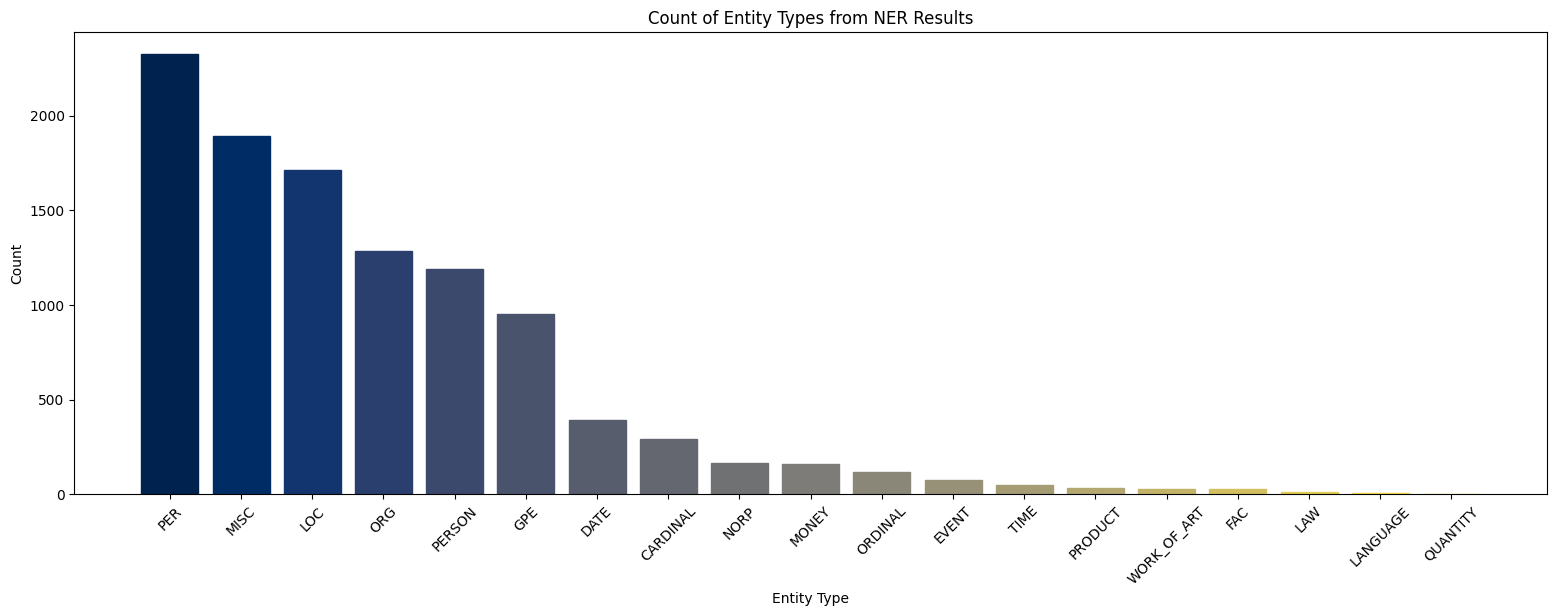

In [33]:
types, counts = count_entities(ner_results)

plt.figure(figsize=(19, 6))
bars = plt.bar(types, counts, color=plt.cm.cividis(np.linspace(0, 1, len(types))))
plt.xlabel('Entity Type')
plt.ylabel('Count')
plt.title('Count of Entity Types from NER Results')
plt.xticks(rotation=45)

for bar, color in zip(bars, plt.cm.cividis(np.linspace(0, 1, len(types)))):
    bar.set_color(color)

plt.show()

Method to get the most common entities

In [34]:
def get_commons(df: pd.DataFrame) -> dict:
    """
    Finds the most common values for each entity type and removes newline characters from entity names.\n
    ---
    ### Args
    - `df` `(pd.DataFrame)`: DataFrame containing NER results.\n
    ---
    ### Returns
    - `dict`: dictionary with entity types as keys and counters of their values.
    """
    entity_counters = defaultdict(Counter)
    
    for ner_list in df['ner']:
        for entity, entity_type in eval(ner_list):
            cleaned_entity = entity.replace("\n", '')
            entity_counters[entity_type][cleaned_entity] += 1
    
    return entity_counters

Display the most common entities for each category

In [35]:
common_entities = get_commons(ner_results)

for entity_type, counter in common_entities.items():
    print(f"\nMost common entities for {entity_type}:")
    for entity, count in counter.most_common(3):
        print(f"- {entity}: {count}")


Most common entities for ORG:
- Corinthians: 87
- RT @thevivafrei:: 54
- RT @BRASILWIRE: 36

Most common entities for GPE:
- Brazil: 573
- BRAZIL: 69
- US: 66

Most common entities for CARDINAL:
- #: 93
- 30: 30
- 👋: 18

Most common entities for PERSON:
- Lula: 270
- Jair Bolsonaro: 57
- RT @RafaelFontana: 51

Most common entities for NORP:
- Brazilian: 70
- 🤏: 30
- Cuban: 12

Most common entities for DATE:
- today: 54
- Today: 45
- 2022: 39

Most common entities for TIME:
- this morning: 9
- a few hours: 6
- 1 pm ET: 6

Most common entities for ORDINAL:
- third: 51
- first: 36
- second: 17

Most common entities for EVENT:
- New Year: 21
- Inauguration Day: 12
- Inauguration Day @GovWhitmer: 6

Most common entities for WORK_OF_ART:
- Lula’s: 6
- Radio Edit: 6
- Hate: 3

Most common entities for MONEY:
- #百家乐 #: 9
- #Basavatarakam Indo-A: 9
- #世界杯 #: 6

Most common entities for FAC:
- the Gabba: 6
- the Empire State Plaza Convention Center: 6
- View: 3

Most common entities for PER:
- 

---

### Task 5: Sentiment Analysis

TwitterRoBERTa class for sentiment analysis

In [36]:
class TwitterRoBERTaXLM:
    def __init__(
            self,
            model_dir: Optional[Union[str, os.PathLike]] = f"cardiffnlp/twitter-xlm-roberta-base-sentiment"
        ) -> None:
        logger.info(f"Initializing TwitterRoBERTaXLM...")

        try:
            if torch.cuda.is_available():
                torch.cuda.synchronize()
                torch.cuda.empty_cache()

            self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
            self.tokenizer = AutoTokenizer.from_pretrained(model_dir, use_fast=False)
            self.config = AutoConfig.from_pretrained(model_dir, use_fast=False)
            self.model: torch.nn.Module = AutoModelForSequenceClassification.from_pretrained(model_dir)
            self.model.to(self.device)
            logger.info(f"Model initialized on device: '{self.device}'")

        except Exception as e:
            logger.error(f"Failed to initialize TwitterRoBERTaXLM: {e}")
            raise

    # Preprocess text (username and link placeholders)
    @classmethod
    def _preprocess(
            cls,
            text: str
        ) -> str:
        """
        Preprocess text.\n
        ---
        ### Args
        - `text` (`str`): the text to preprocess.\n
        ---
        ### Retutrns
        - `str`: the preprocessed text.
        """
        new_text = []

        try:
            for t in text.split(" "):
                t = '@user' if t.startswith('@') and len(t) > 1 else t
                t = 'http' if t.startswith('http') else t
                new_text.append(t)

            return " ".join(new_text)

        except Exception as e:
            logger.exception(f"Failed to preprocess text: {e}")
            raise

    def evaluate(
            self, 
            text: str
        ) -> str:
        """
        Evaluate the sentiment on a text.\n
        ---
        ### Args:
        - `text` (`str`): the text to evaluate.\n
        ---
        ### Returns
        - `str`: the predicted label.
        """
        text = self._preprocess(text)
        try:
            encoded_input = self.tokenizer(
                text,
                return_tensors='pt',
                max_length=512,
                truncation=True
            ).to(self.device)

            output = self.model(**encoded_input)
            scores = output[0][0].detach().cpu().numpy()
            scores = softmax(scores)
            ranking = np.argsort(scores)[::-1]

            results = [(self.config.id2label[ranking[i]], np.round(float(scores[ranking[i]]), 4)) for i in range(scores.shape[0])]

            return results[0][0]

        except Exception as e:
            logger.exception(f"Failed to process text: {e}")
            raise

    def __call__(
            self,
            df: pd.DataFrame
        ) -> pd.DataFrame:
        """
        Evaluate the sentiment of all the text in a dataframe.\n
        ---
        ### Args
        - `df`: the dataframe.\n
        ---
        ### Returns
        - `pd.DataFrame`: the augmented dataframe.
        """
        logger.info(f"Performing sentiment analysis on the dataframe...")
        try:
            df['sentiment'] = df['text'].apply(lambda x: self.evaluate(x))

        except Exception as e:
            logger.error(f"Failed to do sentiment analysis: {e}")
            raise

        return df

sentiment_model = TwitterRoBERTaXLM(TWITTER_ROBERTA_XLM_DIR)

[2024-07-09 21:05:23,551][INFO][Notebook] Initializing TwitterRoBERTaXLM...


[2024-07-09 21:05:31,719][INFO][Notebook] Model initialized on device: 'cuda'


Do the sentiment analysis

In [37]:
sentiment_results = sentiment_model(ner_results)

[2024-07-09 21:05:32,106][INFO][Notebook] Performing sentiment analysis on the dataframe...


[2024-07-09 21:07:10,665][INFO][Notebook] Sentiment results:
sentiment
positive    1797
neutral     1779
negative     924
Name: count, dtype: int64



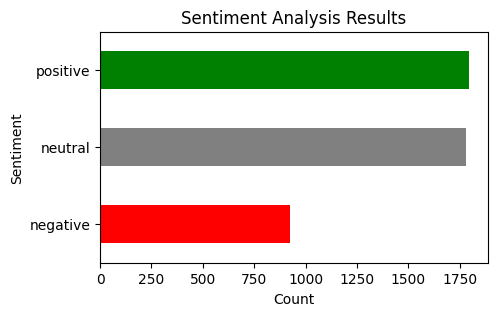

In [38]:
lula_sentiment_counts = sentiment_results['sentiment'].value_counts()
logger.info(f"Sentiment results:\n{lula_sentiment_counts}\n")

plt.figure(figsize=(5, 3))
colors = ['red' if sentiment == 'negative' else 'green' if sentiment == 'positive' else 'grey' for sentiment in lula_sentiment_counts.index]
lula_sentiment_counts.plot(kind='barh', color=colors)
plt.xlabel('Count')
plt.ylabel('Sentiment')
plt.title('Sentiment Analysis Results')
plt.gca().invert_yaxis()
plt.show()

---

### Task 6: Data Visualizations

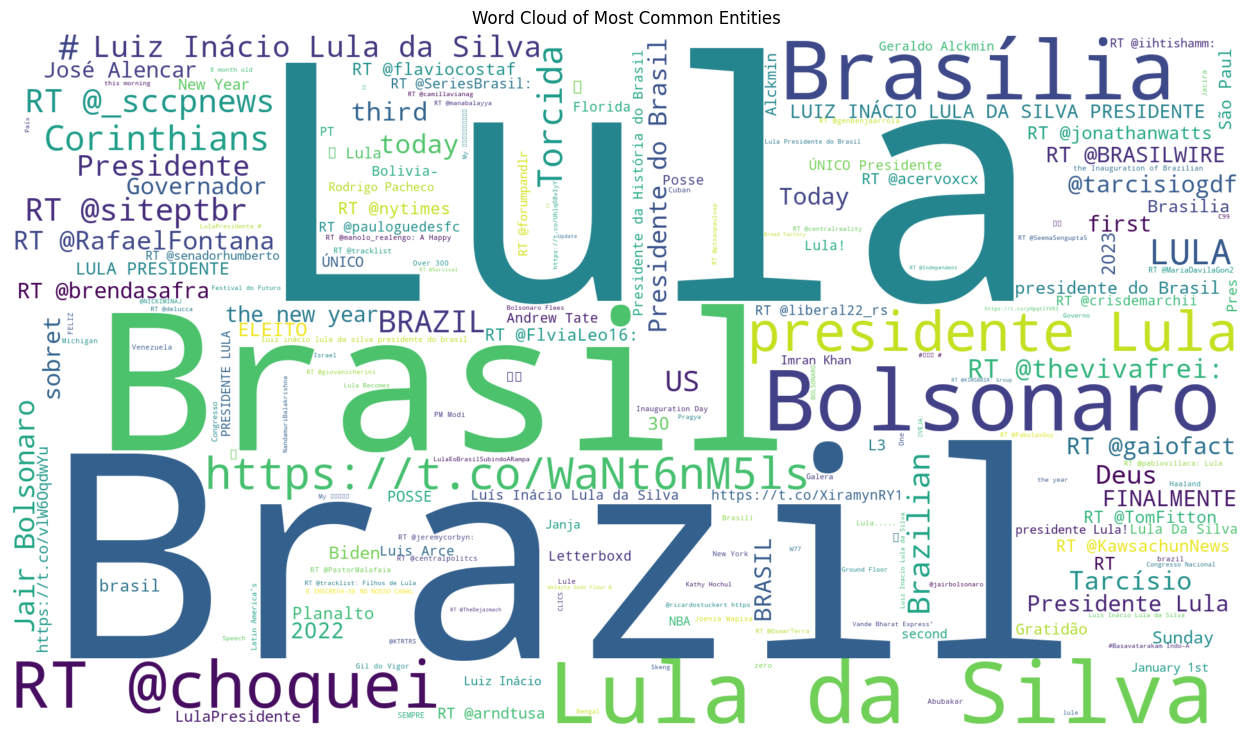

In [39]:
combined_counter = Counter()
for counter in common_entities.values():
    combined_counter.update(counter)

wordcloud = WordCloud(
    width = 1920,
    height = 1080, 
    background_color = 'white'
).generate_from_frequencies(combined_counter)

plt.figure(figsize=(16, 9))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Most Common Entities')
plt.show()

Display sentiment counts

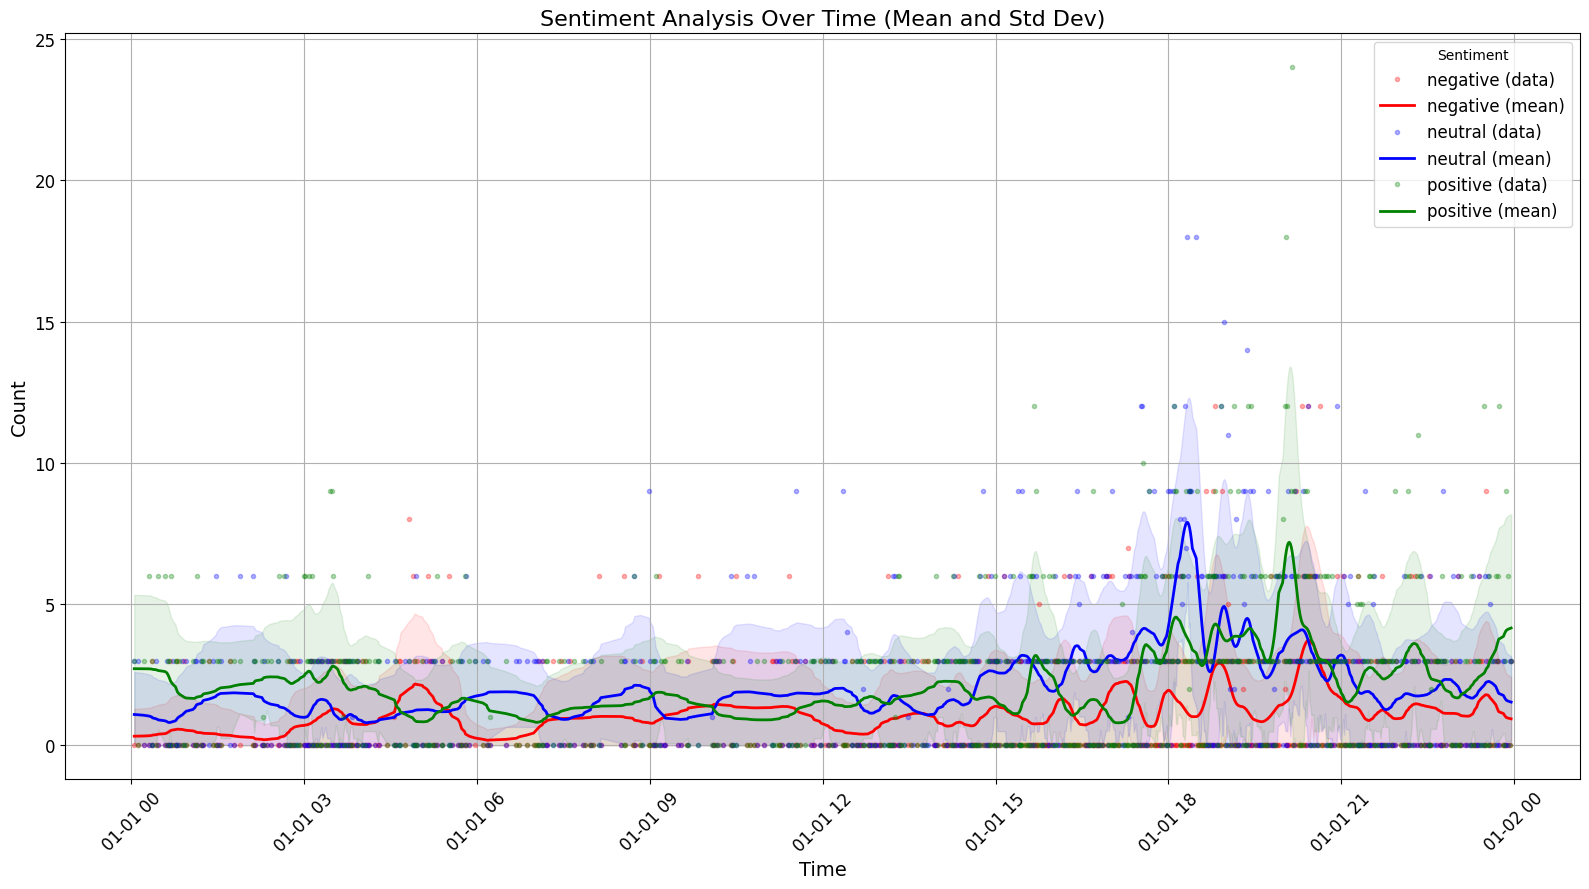

In [40]:
sentiment_results['created_at'] = pd.to_datetime(sentiment_results['created_at'])
sentiment_results['datetime'] = sentiment_results['created_at'].dt.floor('min')

sentiment_counts_by_datetime = sentiment_results.groupby(['datetime', 'sentiment']).size().unstack(fill_value=0)

plt.figure(figsize=(16, 9))

colors = {
    'negative': 'red',
    'neutral': 'blue',
    'positive': 'green'
}

for sentiment in sentiment_counts_by_datetime.columns:
    if sentiment_counts_by_datetime[sentiment].sum() == 0:
        continue
    
    mean_values = sentiment_counts_by_datetime[sentiment].rolling(window=10, center=True).mean()
    std_values = sentiment_counts_by_datetime[sentiment].rolling(window=10, center=True).std()
    
    mean_values = mean_values.interpolate(method='linear', limit_direction='both')
    std_values = std_values.interpolate(method='linear', limit_direction='both')
    
    plt.plot(
        sentiment_counts_by_datetime.index, 
        sentiment_counts_by_datetime[sentiment], 
        '.',
        alpha=0.3,
        label=f'{sentiment} (data)',
        color=colors[sentiment])
    
    plt.plot(
        sentiment_counts_by_datetime.index, 
        gaussian_filter1d(mean_values, sigma=5), 
        '-',
        linewidth=2, 
        label=f'{sentiment} (mean)', 
        color=colors[sentiment])
    
    plt.fill_between(
        sentiment_counts_by_datetime.index, 
        np.maximum(mean_values - std_values, 0), 
        gaussian_filter1d(mean_values + std_values, sigma=5), 
        color=colors[sentiment],
        alpha=0.1)

plt.xlabel('Time', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title('Sentiment Analysis Over Time (Mean and Std Dev)', fontsize=16)
plt.legend(title='Sentiment', fontsize=12)
plt.grid(True)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

plt.show()

Show the hour count

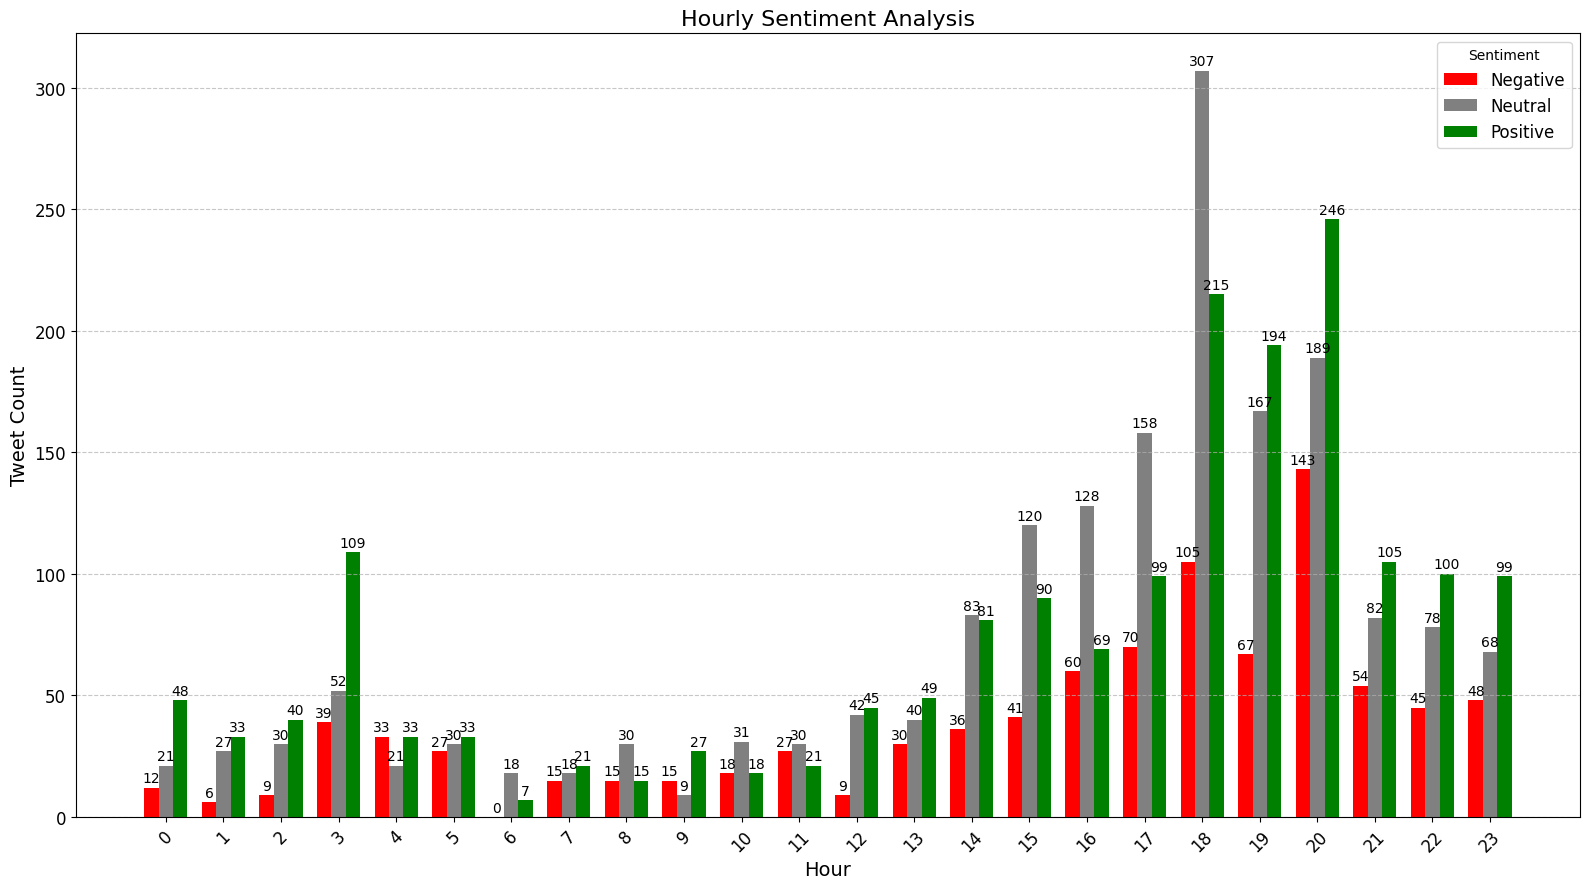

In [41]:
sentiment_results['created_at'] = pd.to_datetime(sentiment_results['created_at'])
sentiment_results['hour'] = sentiment_results['created_at'].dt.hour

hourly_sentiment_counts = sentiment_results.groupby(['hour', 'sentiment']).size().unstack(fill_value=0)

plt.figure(figsize=(16, 9))
colors = {
    'negative': 'red',
    'neutral': 'grey',
    'positive': 'green'
}

bar_width = 0.25
hours = hourly_sentiment_counts.index

for i, sentiment in enumerate(hourly_sentiment_counts.columns):
    sentiment_counts = hourly_sentiment_counts[sentiment]
    plt.bar(
        hours + i * bar_width, 
        sentiment_counts, 
        width = bar_width, 
        color = colors[sentiment], 
        label = sentiment.capitalize())
    
    for hour, count in zip(hours, sentiment_counts):
        plt.text(
            hour + i * bar_width, 
            count + 1, 
            str(count), 
            ha = 'center', 
            va = 'bottom')

plt.xlabel('Hour', fontsize=14)
plt.ylabel('Tweet Count', fontsize=14)
plt.title('Hourly Sentiment Analysis', fontsize=16)
plt.xticks(hours + bar_width, hours, rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Sentiment', fontsize=12)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()

### Task 6: Data Visualizations

Networkx Graph wrapper class implementation

In [42]:
class Graph(nx.DiGraph):
    def __init__(
            self,
            data: pd.DataFrame
        ) -> None:
        """
        Initialize the Graph object with tweet data.\n
        ---
        ### Args
        - `data` (`pd.DataFrame`): DataFrame containing tweet data.
        """
        super().__init__(incoming_graph_data=None)
        self.data = data
        self.mention_counts = {}
        self.sentiment_scores = {}

        self.process_data()

    def process_data(self) -> None:
        """
        Process the tweet data to populate the graph with nodes and edges.
        """
        for _, tweet in self.data.iterrows():
            self._process_mentions_and_sentiment(tweet)

        for _, tweet in self.data.iterrows():
            self._add_nodes_and_edges(tweet)

    def _process_mentions_and_sentiment(
            self,
            tweet: pd.Series
        ) -> None:
        """
        Process mentions and sentiment scores for a single tweet.\n
        ---
        ### Args
        - `tweet` (`pd.Series`): A single tweet data row.
        """
        mentions = tweet.get('entities.mentions', None)
        if pd.notna(mentions) and mentions != '[]':
            mentions = eval(mentions)
            
            for mention in mentions:
                mentioned_user_id = mention['id']
                sentiment = tweet['sentiment']
                self.mention_counts[mentioned_user_id] = self.mention_counts.get(mentioned_user_id, 0) + 1
                
                if sentiment == 'positive':
                    self.sentiment_scores[mentioned_user_id] = self.sentiment_scores.get(mentioned_user_id, 0) + 1
                    
                elif sentiment == 'negative':
                    self.sentiment_scores[mentioned_user_id] = self.sentiment_scores.get(mentioned_user_id, 0) - 1

    def _add_nodes_and_edges(self, tweet: pd.Series) -> None:
        """
        Add nodes and edges for a single tweet.\n
        ---
        ### Args
        - `tweet` (`pd.Series`): A single tweet data row.
        """
        user_id = tweet['author_id']
        user_name = tweet['username']
        
        mention_count = self.mention_counts.get(user_id, 0)
        sentiment_score = self.sentiment_scores.get(user_id, 0)

        if mention_count > 0:
            self.add_node(
                user_id,
                name = user_name,
                size = mention_count * 50,
                sentiment_score = sentiment_score,
                label=user_name if mention_count > 10 else ''
            )

        mentions = tweet.get('entities.mentions', None)
        if pd.notna(mentions) and mentions != '[]':
            mentions = eval(mentions) 
            
            for mention in mentions:
                mentioned_user_id = mention['id']
                mentioned_user_name = mention['username']

                if mentioned_user_id not in self.nodes:
                    self.add_node(
                        mentioned_user_id,
                        name = mentioned_user_name,
                        size = self.mention_counts.get(mentioned_user_id, 0) * 50,
                        sentiment_score = self.sentiment_scores.get(mentioned_user_id, 0),
                        label = mentioned_user_name if self.mention_counts.get(mentioned_user_id, 0) > 50 else ''
                    )

                self.add_edge(
                    mentioned_user_id,
                    user_id,
                    interaction='mention'
                )

    def plot(self) -> None:
        """
        Plot the Twitter user interaction network.
        """
        plt.figure(figsize=(20, 20))
        pos = nx.spring_layout(
            G = self,
            k = 0.3,
            iterations = 10,
            scale = 100,
            weight = 'size'
        )

        sizes = [self.nodes[node].get('size', 10) for node in self.nodes]
        cmap = LinearSegmentedColormap.from_list('sentiment_cmap', ['red', 'grey', 'green'])
        sentiment_scores = [self.nodes[node].get('sentiment_score', 0) for node in self.nodes]
        max_score = max(sentiment_scores) if sentiment_scores else 1
        colors = [cmap((score + max_score) / (2 * max_score)) for score in sentiment_scores]

        nx.draw_networkx_nodes(
            G = self,
            pos = pos,
            node_size = sizes,
            node_color = colors,
            alpha = 0.7
        )

        edges_mentions = [(u, v) for u, v, d in self.edges(data=True) if d['interaction'] == 'mention']
        nx.draw_networkx_edges(
            G = self,
            pos = pos,
            edgelist = edges_mentions,
            edge_color = 'black',
            alpha = 0.2,
            arrowstyle = '<|-'
        )

        labels = {node: self.nodes[node]['label'] for node in self.nodes if 'label' in self.nodes[node] and self.nodes[node]['label']}
        nx.draw_networkx_labels(
            G = self,
            pos = pos,
            labels = labels,
            font_size = 18
        )

        plt.title('Twitter User Interaction Network', fontsize=20)
        plt.axis('off')
        plt.show()

    def top_influential_users(self, top_n: int = 10) -> pd.DataFrame:
        """
        Get the top N influential users based on degree centrality.\n
        ---
        ### Args
        - `top_n` (`int`): Number of top users to return. Default is `10`.\n
        ---
        ### Returns
        - `pd.DataFrame`: DataFrame of the top N influential users.
        """
        degree_centrality = nx.degree_centrality(self)
        sorted_degree_centrality = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)

        top_users_data = []
        for idx, (user_id, centrality) in enumerate(sorted_degree_centrality[:top_n]):
            user_name = self.nodes[user_id].get('name')
            goodness_score = self.nodes[user_id].get('sentiment_score', 0)
            
            top_users_data.append({
                'Rank': idx + 1,
                'Username': f"@{user_name}",
                'Centrality': f"{(centrality * 100):.2f}%",
                'Goodness': goodness_score
            })

        top_users_df = pd.DataFrame(top_users_data)
        return top_users_df
        
graph = Graph(sentiment_results)

Create and draw the graph

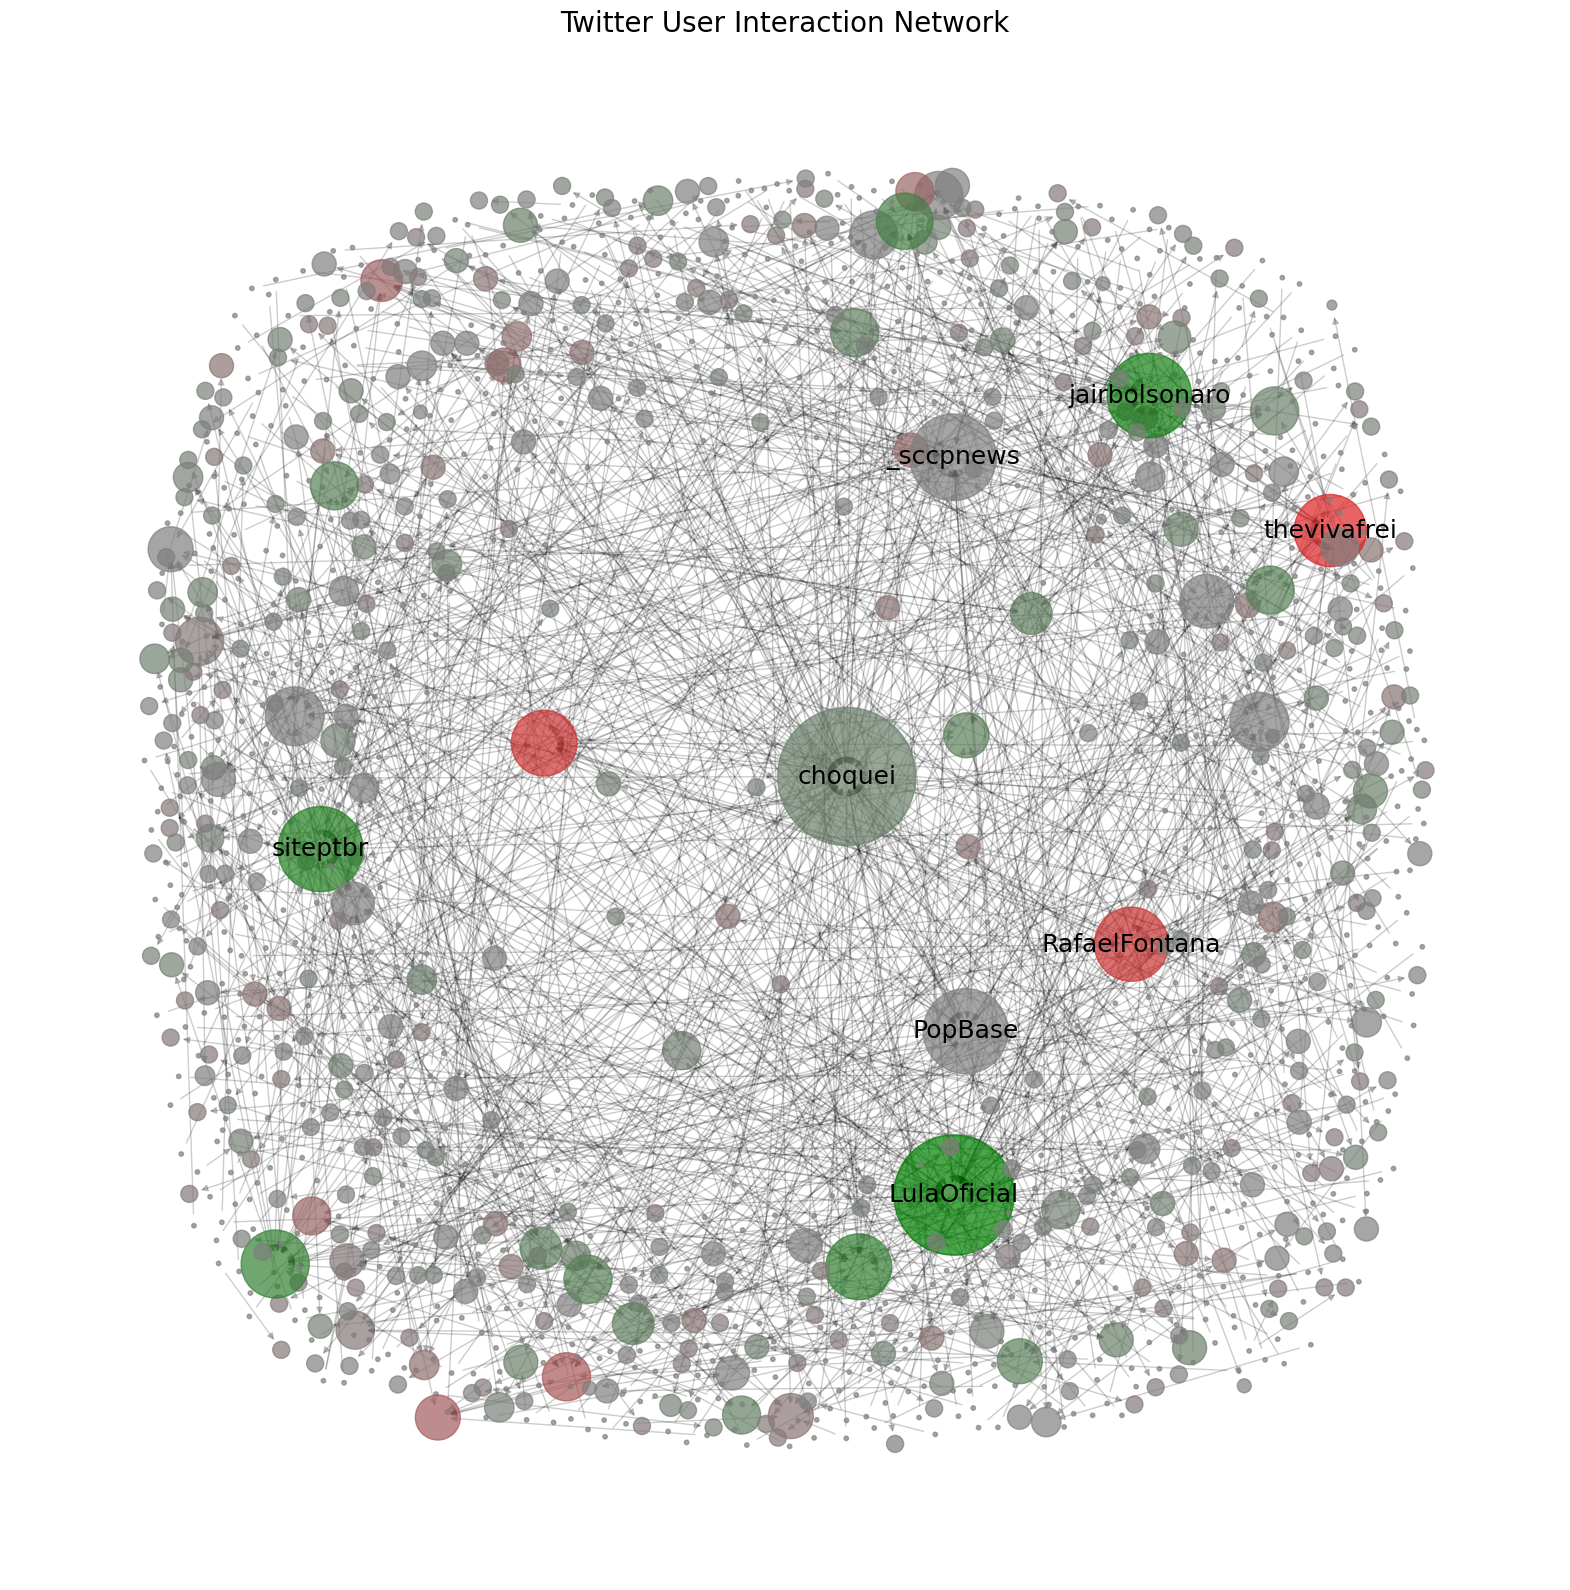

[2024-07-09 21:07:23,895][INFO][Notebook] Top 10 influential users based on degree centrality:
   Rank        Username Centrality  Goodness
0     1        @choquei      4.54%        12
1     2    @LulaOficial      3.09%        75
2     3      @_sccpnews      1.79%         0
3     4        @PopBase      1.72%         0
4     5  @jairbolsonaro      1.72%        63
5     6       @siteptbr      1.72%        54
6     7    @thevivafrei      1.24%       -54
7     8    @tarcisiogdf      1.10%        45
8     9     @Fa1ryNight      1.03%        45
9    10       @gaiofact      1.03%       -45


In [43]:
graph.plot()
top_users = graph.top_influential_users()
logger.info(f"Top 10 influential users based on degree centrality:\n{top_users}")

Get the top localities

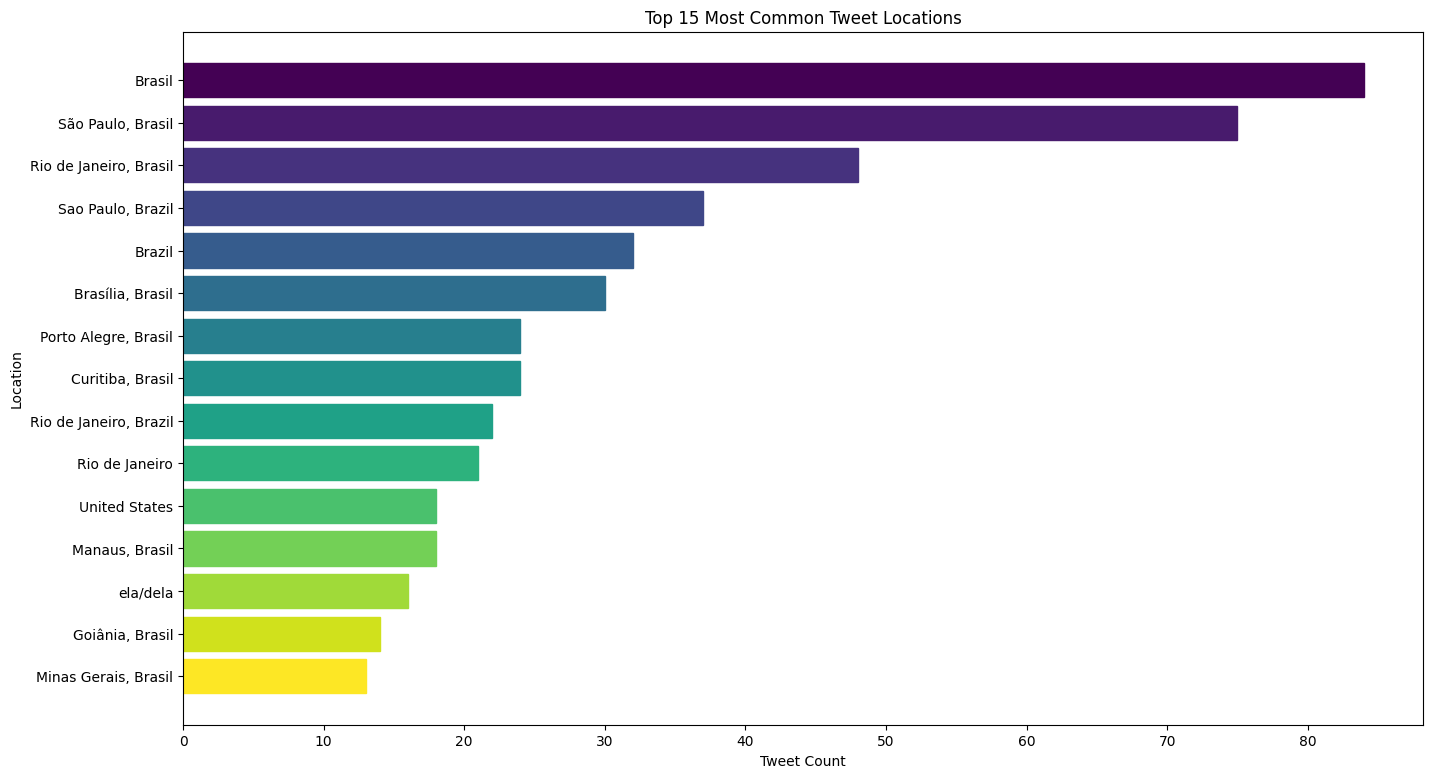

In [44]:
state_df = sentiment_results[['location']].dropna()
location_counts = state_df['location'].value_counts().reset_index()
location_counts.columns = ['location', 'tweet_count']

top_n = 15
top_locations = location_counts.head(top_n)

plt.figure(figsize=(16, 9))
bars = plt.barh(top_locations['location'], top_locations['tweet_count'], color=plt.cm.viridis(np.linspace(0, 1, top_n)))
plt.xlabel('Tweet Count')
plt.ylabel('Location')
plt.title(f'Top {top_n} Most Common Tweet Locations')
plt.gca().invert_yaxis()

for bar, color in zip(bars, plt.cm.viridis(np.linspace(0, 1, top_n))):
    bar.set_color(color)

plt.show()

In [62]:
logger.info(f"Top 50 locations:\n{location_counts.head(50)}")

[2024-07-09 22:57:30,178][INFO][Notebook] Top 50 locations:
                     location  tweet_count
0                      Brasil           84
1           São Paulo, Brasil           75
2      Rio de Janeiro, Brasil           48
3           Sao Paulo, Brazil           37
4                      Brazil           32
5            Brasília, Brasil           30
6        Porto Alegre, Brasil           24
7            Curitiba, Brasil           24
8      Rio de Janeiro, Brazil           22
9              Rio de Janeiro           21
10              United States           18
11             Manaus, Brasil           18
12                   ela/dela           16
13            Goiânia, Brasil           14
14       Minas Gerais, Brasil           13
15     Belo Horizonte, Brasil           12
16          Sao Paulo, Brasil           12
17         Pernambuco, Brasil           12
18                      Earth           12
19            Niterói, Brasil           12
20                        NYC        

---